<a href="https://colab.research.google.com/github/oneash98/FastCampusDeepLearning/blob/main/Chapter_05_Clustering_06_Mini_PJT_%E1%84%89%E1%85%AD%E1%84%91%E1%85%B5%E1%86%BC%E1%84%86%E1%85%A9%E1%86%AF_%E1%84%89%E1%85%A1%E1%84%8B%E1%85%AD%E1%86%BC%E1%84%8C%E1%85%A1_%E1%84%80%E1%85%A9%E1%84%80%E1%85%A2%E1%86%A8_%E1%84%89%E1%85%A6%E1%84%87%E1%85%AE%E1%86%AB%E1%84%92%E1%85%AA(%E1%84%89%E1%85%B5%E1%86%AF%E1%84%89%E1%85%B3%E1%86%B8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mini PJT

- 해당 데이터를 고객 단위로 묶어야 합니다.


- 데이터를 정제해서, 월별/고객별로 재정렬이 필요합니다. (aggregation)


- row가 고객별 데이터로 묶이고 난 다음, 고객들을 유형별로 나눠봅니다.


- 여러 가지 클러스터링 알고리즘을 사용하여, 결과를 테스트해봅니다.


- 클러스터링을 위한 전처리부터, 평가까지 모든 항목을 하나하나 살펴보면서 데이터를 뜯어봅니다.

### Data Description

Source : https://www.kaggle.com/c/instacart-market-basket-analysis

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. 데이터 불러오기 

In [3]:
# instacart 데이터를 모두 불러옵니다.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

base_path = "/content/drive/MyDrive/Colab Notebooks/FastCampusDeepLearning/머신러닝/data/instacart-market-basket-analysis/"
aisles = pd.read_csv(base_path + "aisles.csv")
departments = pd.read_csv(base_path + "departments.csv")
prior = pd.read_csv(base_path + "order_products__prior.csv")
train = pd.read_csv(base_path + "order_products__train.csv")
orders = pd.read_csv(base_path + "orders.csv")
products = pd.read_csv(base_path + "products.csv")

In [4]:
print(aisles.shape, departments.shape, prior.shape, train.shape, orders.shape, products.shape)

(134, 2) (21, 2) (32434489, 4) (1384617, 4) (3421083, 7) (49688, 4)


In [5]:
prior_sample = prior[:10000]
prior_sample

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
9995,1022,21903,1,1
9996,1022,38689,2,1
9997,1022,30391,3,1
9998,1022,18670,4,1


In [6]:
# 불러온 모든 테이블을 합칩니다.
temp = pd.merge(orders, prior_sample, on="order_id")
temp = pd.merge(temp, products, on="product_id")
temp = pd.merge(temp, aisles, on="aisle_id")
temp = pd.merge(temp, departments, on="department_id")
temp

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,40,382,prior,29,1,15,23.0,10070,1,1,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
1,235,58701,prior,20,5,9,9.0,10070,7,1,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
2,581,76141,prior,3,6,17,7.0,10070,3,0,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
3,649,135836,prior,1,4,7,NaN,10070,1,0,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
4,40,382,prior,29,1,15,23.0,34866,4,1,Chocolate Milk 1% Milkfat,84,16,milk,dairy eggs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,152,103040,prior,12,1,10,7.0,5161,3,1,Dried Mango,18,10,bulk dried fruits vegetables,bulk
9996,959,119941,prior,2,6,13,21.0,5161,3,1,Dried Mango,18,10,bulk dried fruits vegetables,bulk
9997,400,180454,prior,32,0,8,8.0,5161,3,1,Dried Mango,18,10,bulk dried fruits vegetables,bulk
9998,18,118860,prior,3,4,20,6.0,1000,3,0,Apricots,18,10,bulk dried fruits vegetables,bulk


### 2. EDA

In [13]:
# 10만개의 거래내역에 대해서 각 물품을 얼마나 샀을까?
# temp.user_id.value_counts() # 972명의 고객.
# temp.product_name.value_counts()
# temp.aisle.value_counts()
# temp.department.value_counts()
# temp.order_dow.value_counts()
temp.order_hour_of_day.value_counts()

12    903
13    821
9     818
16    815
10    813
11    793
15    775
17    771
14    706
8     601
18    546
20    373
19    335
7     231
22    175
21    172
23    134
6      95
0      76
1      26
4      16
2       5
Name: order_hour_of_day, dtype: int64

### 3. 데이터 전처리

- 데이터를 transaction 단위로 변경합니다.

- 각자의 방법대로 데이터의 단위를 정해봅시다.


> User 단위로 어떤 물품을 구매했는지의 정보만 가지는 feature vector로 변환한다. e.g. pd.crosstab, CountVectorizer

In [15]:
# transaction->user-level 단위로 변경하고, User당 정보로 변환하는 과정까지 마무리합니다.
# 1. Department(v)     2. aisle       3. Product_name

X = pd.crosstab(index=temp.user_id, columns=temp.department)
X

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
382,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
503,0,0,0,0,1,0,2,1,0,0,...,0,0,1,0,0,1,0,0,2,0
971,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1059,0,0,3,0,3,0,0,8,0,0,...,0,1,2,0,0,2,0,0,8,2
1177,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204184,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
204484,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,4,1
204912,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0


### 4. 클러스터링 모델 적용하기

- 사용하는 클러스터링 모델은 KMeans로 합니다.

(원하시면 AgglomerativeClustering, DBSCAN, SpectralClustering을 사용해보셔도 됩니다. 단, 시간이 매우매우 오래 걸릴수 있으니 주의하세요..)

**[K-Means]**

- Elbow method를 이용하여 최적의 K값을 찾아보세요.


- sparse한 특징을 가지는 데이터를 클러스터링 하기 위해서는 어떤 기법을 사용해야 할까요?


- 클러스터링 결과를 시각화해보고, 실루엣 지수도 계산해봅시다.

In [16]:
# data setting
X

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
382,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
503,0,0,0,0,1,0,2,1,0,0,...,0,0,1,0,0,1,0,0,2,0
971,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1059,0,0,3,0,3,0,0,8,0,0,...,0,1,2,0,0,2,0,0,8,2
1177,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204184,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
204484,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,4,1
204912,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0


In [19]:
# tSNE : 시각화용도의 차원감소 기법. (2차원으로 변환해주는 기법)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(X)
tsne_data

array([[-25.546991 ,  -1.6012747],
       [ -8.721932 , -22.985306 ],
       [-22.839111 ,   8.614365 ],
       ...,
       [-10.495918 ,  12.122653 ],
       [-31.809196 ,  -4.738322 ],
       [ 12.543931 ,   9.722735 ]], dtype=float32)

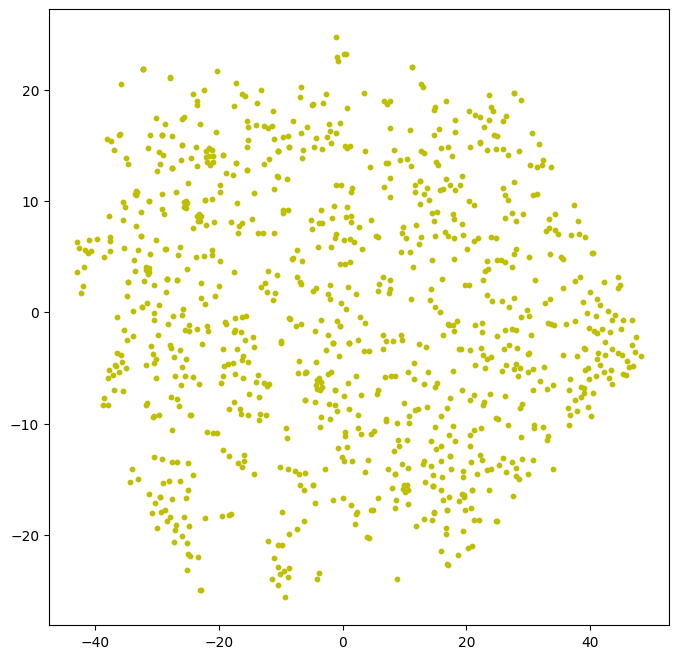

In [20]:
plt.figure(figsize=(8, 8))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], s=10, c='y')
plt.show()

In [36]:
# K-means를 돌려봅시다.
from sklearn.cluster import KMeans                     # 1. K-means
from sklearn.cluster import AgglomerativeClustering    # 2. Hierarchical Agglomerative Clustering
from sklearn.cluster import DBSCAN                     # 3. DBSCAN
from sklearn.cluster import SpectralClustering         # 4. Spectral Clustering

from sklearn.metrics import silhouette_score

model = KMeans(n_clusters = 4)
model2 = KMeans(n_clusters = 2)
# unsupervised setting
pred = model.fit_predict(X)
pred2 = model2.fit_predict(X)
print("Silhouette Score : %.4f" % silhouette_score(X, pred))
print("Silhouette Score : %.4f" % silhouette_score(X, pred2))

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score : 0.1910
Silhouette Score : 0.3641


In [28]:
# elbow method
sse = []
silhouettes = []

for K in range(2, 11):
  model = KMeans(n_clusters = K) # K : 2 - 10
  pred = model.fit_predict(X)
  sse.append(model.inertia_) # SSE
  silhouettes.append(silhouette_score(X, pred))

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

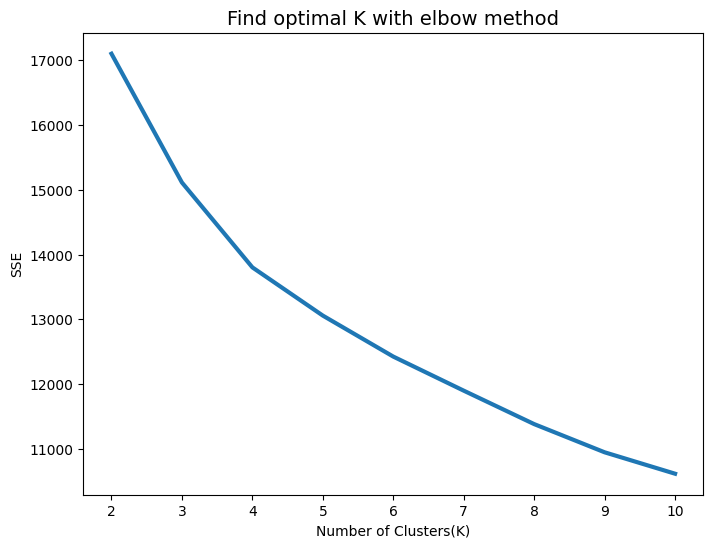

In [32]:
# 최적의 K는 어떻게 구할까요?
# Elbow method : 정해진 K에 대해서 SSE를 계산한 다음, SSE가 가장 많이 꺾이는 K(elbow)가 optimal K라고 판단하는 방법.

plt.figure(figsize=(8, 6))
plt.title("Find optimal K with elbow method", fontsize=14)
plt.xlabel("Number of Clusters(K)", fontsize=10)
plt.ylabel("SSE", fontsize=10)
plt.plot(range(2, 11), sse, lw=3)
plt.show()

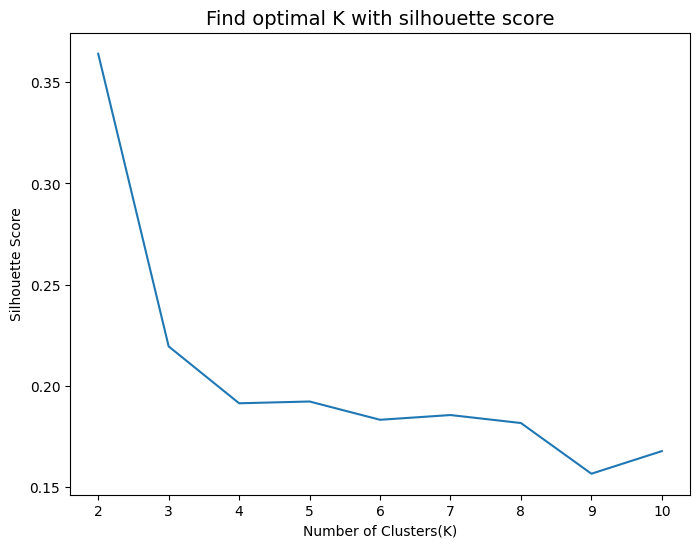

In [34]:
# Silhouette score : 같은 클러스터에 속하는 데이터중 가장 먼 데이터와의 거리와 다른 클러스터에 속하는 데이터 중 가장 가까운 데이터와의 거리 비율을 계산한 지표. [-1, 1]
# Reference : https://en.wikipedia.org/wiki/Silhouette_(clustering)

plt.figure(figsize=(8, 6))
plt.title("Find optimal K with silhouette score", fontsize=14)
plt.xlabel("Number of Clusters(K)", fontsize=10)
plt.ylabel("Silhouette Score", fontsize=10)
plt.plot(range(2, 11), silhouettes)
plt.show()

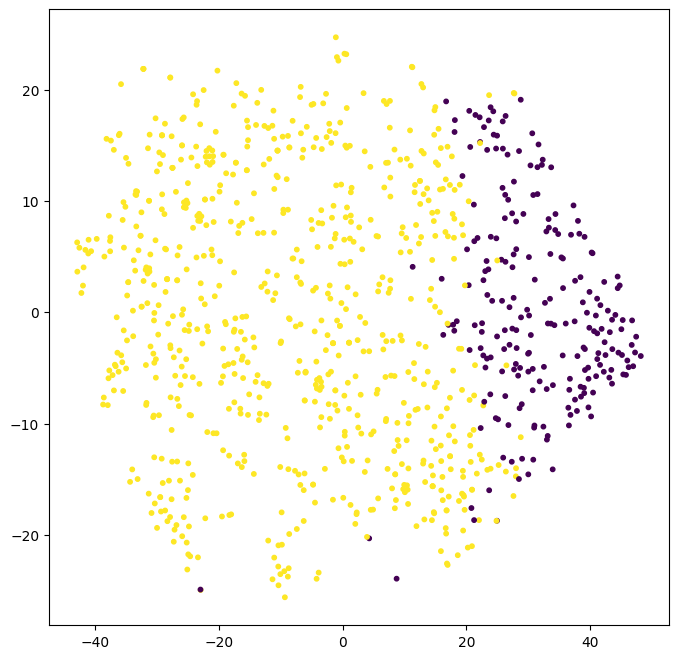

In [38]:
plt.figure(figsize=(8, 8))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], s=10, c = pred2, cmap="viridis")
plt.show()

In [47]:
# see summary
X["cluster_label"] = pred2
X["Cluster_label"] = pred
X

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,meat seafood,missing,other,pantry,personal care,pets,produce,snacks,cluster_label,Cluster_label
user_id,,,,,,,,,,,,,,,,,,,,,
382,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,2
503,0,0,0,0,1,0,2,1,0,0,...,1,0,0,1,0,0,2,0,1,2
971,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,2
1059,0,0,3,0,3,0,0,8,0,0,...,2,0,0,2,0,0,8,2,0,3
1177,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,2,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204184,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
204484,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,4,1,1,1
204912,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,1,0,1,2


In [51]:
group1 = X.loc[X.Cluster_label == 0, :]
group2 = X.loc[X.Cluster_label == 1, :]
group3 = X.loc[X.Cluster_label == 2, :]
group4 = X.loc[X.Cluster_label == 3, :]
print(group1.shape, group2.shape, group3.shape, group4.shape)

(82, 23) (284, 23) (493, 23) (113, 23)


In [52]:
group1.mean() 

department
alcohol             0.012195
babies              0.243902
bakery              0.560976
beverages           1.353659
breakfast           0.317073
bulk                0.036585
canned goods        0.768293
dairy eggs          3.036585
deli                0.853659
dry goods pasta     0.426829
frozen              1.280488
household           0.317073
international       0.134146
meat seafood        0.329268
missing             0.012195
other               0.000000
pantry              0.975610
personal care       0.097561
pets                0.073171
produce            10.621951
snacks              1.304878
cluster_label       0.000000
Cluster_label       0.000000
dtype: float64

In [53]:
group2.mean()

department
alcohol            0.017606
babies             0.095070
bakery             0.345070
beverages          0.598592
breakfast          0.193662
bulk               0.007042
canned goods       0.464789
dairy eggs         1.302817
deli               0.320423
dry goods pasta    0.235915
frozen             0.535211
household          0.200704
international      0.095070
meat seafood       0.278169
missing            0.017606
other              0.010563
pantry             0.559859
personal care      0.084507
pets               0.014085
produce            4.352113
snacks             0.580986
cluster_label      0.700704
Cluster_label      1.000000
dtype: float64

In [54]:
group3.mean()

department
alcohol            0.040568
babies             0.085193
bakery             0.233266
beverages          0.770791
breakfast          0.176471
bulk               0.002028
canned goods       0.225152
dairy eggs         1.002028
deli               0.200811
dry goods pasta    0.176471
frozen             0.569980
household          0.259635
international      0.056795
meat seafood       0.129817
missing            0.006085
other              0.018256
pantry             0.432049
personal care      0.119675
pets               0.022312
produce            0.831643
snacks             0.626775
cluster_label      1.000000
Cluster_label      2.000000
dtype: float64

In [55]:
group4.mean()

department
alcohol            0.008850
babies             0.371681
bakery             0.840708
beverages          1.238938
breakfast          0.619469
bulk               0.000000
canned goods       0.495575
dairy eggs         4.725664
deli               0.522124
dry goods pasta    0.584071
frozen             1.840708
household          0.336283
international      0.176991
meat seafood       0.486726
missing            0.053097
other              0.008850
pantry             1.292035
personal care      0.300885
pets               0.061947
produce            3.504425
snacks             2.486726
cluster_label      0.513274
Cluster_label      3.000000
dtype: float64